# CLIP Testing Notebook

This notebook tests the CLIP bi-encoder on sample images and texts from the Flickr30K dataset.

## Goals:
1. Load and test the BiEncoder class
2. Encode sample images and texts
3. Verify embedding quality
4. Test similarity search

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

from retrieval import BiEncoder
from flickr30k import Flickr30KDataset
from flickr30k.utils import load_config

print("✓ Imports successful")

✓ Imports successful


## 2. Load Configuration and Dataset

In [2]:
# Load configuration
config = load_config('../configs/clip_config.yaml')
print("Configuration loaded:")
print(f"  Model: {config['model']['name']}")
print(f"  Device: {config['model']['device']}")

Configuration loaded:
  Model: ViT-B-32
  Device: auto


In [3]:
# Load dataset
dataset = Flickr30KDataset(
    images_dir='../data/images',
    captions_file='../data/results.csv'
)

print(f"Dataset: {dataset}")

Loading captions from: ..\data\results.csv
✓ Loaded 158,915 captions for 31,783 images
Dataset: Flickr30KDataset(31,783 images, 158,915 captions)


## 3. Initialize BiEncoder

In [4]:
# Initialize CLIP encoder
encoder = BiEncoder(
    model_name=config['model']['name'],
    pretrained=config['model']['pretrained']
)

print(f"\nEmbedding dimension: {encoder.get_embedding_dim()}")

d:\Giáo trình 20251\IT3930E - Project III\hybrid_multimodal_retrieval\venv\Lib\site-packages\torch\cuda\__init__.py:182: UserWarning: cudaGetDeviceCount() returned cudaErrorNotSupported, likely using older driver or on CPU machine (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:88.)
  return torch._C._cuda_getDeviceCount() > 0


Loading CLIP model: ViT-B-32 (openai)
Using device: cpu


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

d:\Giáo trình 20251\IT3930E - Project III\hybrid_multimodal_retrieval\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ACER\.cache\huggingface\hub\models--timm--vit_base_patch32_clip_224.openai. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
d:\Giáo trình 20251\IT3930E - Project III\hybrid_multimod

✓ CLIP model loaded successfully

Embedding dimension: 512


## 4. Test on Sample Images

In [5]:
# Get 5 random samples
sample_images = dataset.get_unique_images()[:5]

print("Sample images:")
for i, img_name in enumerate(sample_images, 1):
    print(f"{i}. {img_name}")

Sample images:
1. 1000092795.jpg
2. 10002456.jpg
3. 1000268201.jpg
4. 1000344755.jpg
5. 1000366164.jpg


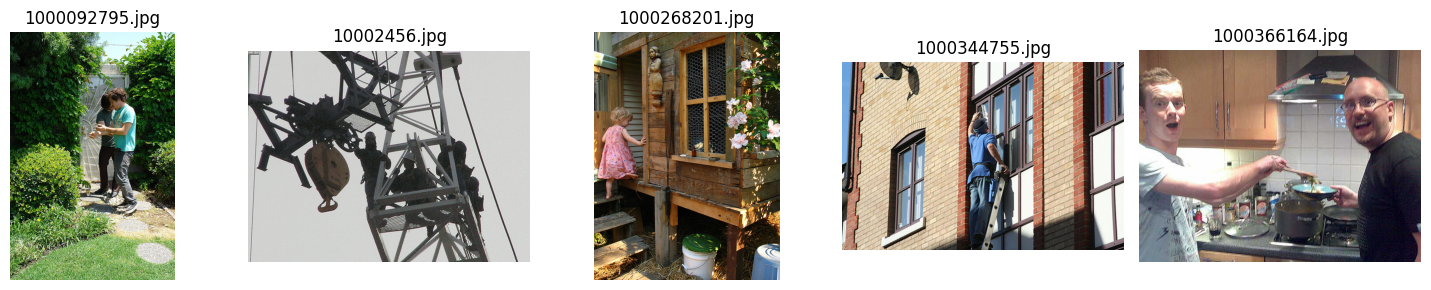

In [6]:
# Load and display sample images
images = []
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, img_name in enumerate(sample_images):
    img = dataset.get_image(img_name)
    images.append(img)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(img_name[:15])

plt.tight_layout()
plt.show()

In [7]:
# Encode images
image_embeddings = encoder.encode_images(images, batch_size=5)

print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Embedding norm: {np.linalg.norm(image_embeddings[0]):.4f}")

Encoding images: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

Image embeddings shape: (5, 512)
Embedding norm: 1.0000


## 5. Test on Sample Texts

In [8]:
# Get captions for first image
sample_captions = dataset.get_captions(sample_images[0])

print(f"Captions for '{sample_images[0]}':")
for i, caption in enumerate(sample_captions, 1):
    print(f"{i}. {caption}")

Captions for '1000092795.jpg':
1. Two young guys with shaggy hair look at their hands while hanging out in the yard .
2. Two young , White males are outside near many bushes .
3. Two men in green shirts are standing in a yard .
4. A man in a blue shirt standing in a garden .
5. Two friends enjoy time spent together .


In [9]:
# Encode captions
text_embeddings = encoder.encode_texts(sample_captions, batch_size=5)

print(f"Text embeddings shape: {text_embeddings.shape}")
print(f"Embedding norm: {np.linalg.norm(text_embeddings[0]):.4f}")

Encoding texts: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

Text embeddings shape: (5, 512)
Embedding norm: 1.0000


## 6. Test Similarity

In [10]:
# Compute similarity between first image and its captions
similarities = image_embeddings[0] @ text_embeddings.T

print("Similarity scores (image vs its own captions):")
for i, (caption, score) in enumerate(zip(sample_captions, similarities), 1):
    print(f"{i}. Score: {score:.4f} - {caption[:60]}...")

Similarity scores (image vs its own captions):
1. Score: 0.2866 - Two young guys with shaggy hair look at their hands while ha...
2. Score: 0.2760 - Two young , White males are outside near many bushes ....
3. Score: 0.2997 - Two men in green shirts are standing in a yard ....
4. Score: 0.2930 - A man in a blue shirt standing in a garden ....
5. Score: 0.2348 - Two friends enjoy time spent together ....


In [12]:
# Test text-to-image retrieval
query_text = "A dog playing in the park"
query_embedding = encoder.encode_texts([query_text])

text_to_image_sim = query_embedding @ image_embeddings.T

print(f"Query: '{query_text}'")
print(f"\nTop matching images:")
top_indices = np.argsort(text_to_image_sim[0])[::-1]
for rank, idx in enumerate(top_indices, 1):
    print(f"{rank}. {sample_images[idx]}: {text_to_image_sim[0][idx]:.4f}")

Encoding texts: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]

Query: 'A dog playing in the park'

Top matching images:
1. 1000092795.jpg: 0.2126
2. 10002456.jpg: 0.1955
3. 1000268201.jpg: 0.1778
4. 1000344755.jpg: 0.1742
5. 1000366164.jpg: 0.1187


## 7. Test Save/Load Functionality

In [13]:
# Save sample embeddings
metadata = {
    'image_names': sample_images,
    'num_images': len(sample_images),
    'model': config['model']['name']
}

encoder.save_embeddings(
    image_embeddings,
    '../data/embeddings/test_image_embeddings.npy',
    metadata=metadata
)

✓ Saved embeddings to ..\data\embeddings\test_image_embeddings.npy
✓ Saved metadata to ..\data\embeddings\test_image_embeddings.json


In [14]:
# Load embeddings back
loaded_embeddings, loaded_metadata = encoder.load_embeddings(
    '../data/embeddings/test_image_embeddings.npy'
)

print(f"\nLoaded metadata:")
print(loaded_metadata)

# Verify they match
assert np.allclose(image_embeddings, loaded_embeddings)
print("\n✓ Save/Load test passed!")

✓ Loaded embeddings from ..\data\embeddings\test_image_embeddings.npy
  Shape: (5, 512)
✓ Loaded metadata from ..\data\embeddings\test_image_embeddings.json

Loaded metadata:
{'image_names': ['1000092795.jpg', '10002456.jpg', '1000268201.jpg', '1000344755.jpg', '1000366164.jpg'], 'num_images': 5, 'model': 'ViT-B-32'}

✓ Save/Load test passed!


## Summary

✅ BiEncoder successfully loaded  
✅ Image encoding working  
✅ Text encoding working  
✅ Similarity computation working  
✅ Save/Load functionality working  

Ready to proceed with full dataset embedding generation!